<a href="https://colab.research.google.com/github/jagadish9084/learnbay-ds-ml-course/blob/main/supervised/linear_regression/life_expectancy_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [246]:
#Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
warnings.filterwarnings('ignore')


In [247]:
# Load dataset
data = pd.read_csv("/content/sample_data/life_expectancy_data.csv")
data.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [248]:
# Check the structure of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

# Data Cleaning and feature engineering

In [249]:
# Standardise the columns name
data.columns = data.columns.str.strip().str.lower().str.replace("[\s/-]+", "_", regex=True)
data.columns

Index(['country', 'year', 'status', 'life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under_five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv_aids', 'gdp', 'population', 'thinness_1_19_years',
       'thinness_5_9_years', 'income_composition_of_resources', 'schooling'],
      dtype='object')

In [250]:
# Drop country code as it will not any have impact on the prediction
data.drop(['country'], axis=1, inplace=True)

In [251]:
# Create functions to check and handle missing values
def check_missing_values(df, percentage):
  missing_values = data.isna().sum()*100/len(data)
  return missing_values[missing_values > percentage]# Converting to map for better visualization
def get_missing_values_columns(df, percentage):
  missing_values = data.isna().sum()*100/len(data)
  return missing_values[missing_values > percentage].index

def handle_missing_values(df, columns):
  for col in columns:
    data[col].fillna(data[col].mean(), inplace=True)


In [252]:
# Handle Missing values
print(f"Columns with missing values before imputation:\n\n{check_missing_values(data, 0)}\n")
handle_missing_values(data, get_missing_values_columns(data, 0))
print(f"Columns with missing values After imputation: {check_missing_values(data, 0)}")

Columns with missing values before imputation:

life_expectancy                     0.340368
adult_mortality                     0.340368
alcohol                             6.603131
hepatitis_b                        18.822328
bmi                                 1.157250
polio                               0.646698
total_expenditure                   7.692308
diphtheria                          0.646698
gdp                                15.248468
population                         22.191967
thinness_1_19_years                 1.157250
thinness_5_9_years                  1.157250
income_composition_of_resources     5.684139
schooling                           5.547992
dtype: float64

Columns with missing values After imputation: Series([], dtype: float64)


In [253]:
# Create functions to handle outliers
def get_outlier_columns(df):
  d = data.select_dtypes(include=np.number)
  q1 = d.quantile(0.25)
  q3 = d .quantile(0.75)
  iqr = q3 - q1
  outlier_counts = ((d < (q1 - 1.5 * iqr)) | (d > (q3 + 1.5 * iqr))).sum()
  return outlier_counts[outlier_counts > 0].index

def plot_outliers():
  sns.set()
  numeric_data = data.select_dtypes(include=np.number)
  total_columns = len(numeric_data.columns)
  fig_col = 4
  fig_row = total_columns // fig_col + total_columns % fig_col
  fig, ax = plt.subplots(fig_row, fig_col, figsize=(15,10))
  column_index = 0
  for row in range(0, fig_row):
    for col in range(0, fig_col):
      if column_index < total_columns:
        sns.boxplot(numeric_data.iloc[:, column_index], ax=ax[row,col])
        column_index +=1
  fig.tight_layout()
  fig.show()

def fix_outliers(df):
  for col in get_outlier_columns(df):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    df[col].clip(lower, upper, inplace=True)

In [254]:
# Get the columns with outliers
get_outlier_columns(data)

Index(['life_expectancy', 'adult_mortality', 'infant_deaths', 'alcohol',
       'percentage_expenditure', 'hepatitis_b', 'measles', 'under_five_deaths',
       'polio', 'total_expenditure', 'diphtheria', 'hiv_aids', 'gdp',
       'population', 'thinness_1_19_years', 'thinness_5_9_years',
       'income_composition_of_resources', 'schooling'],
      dtype='object')

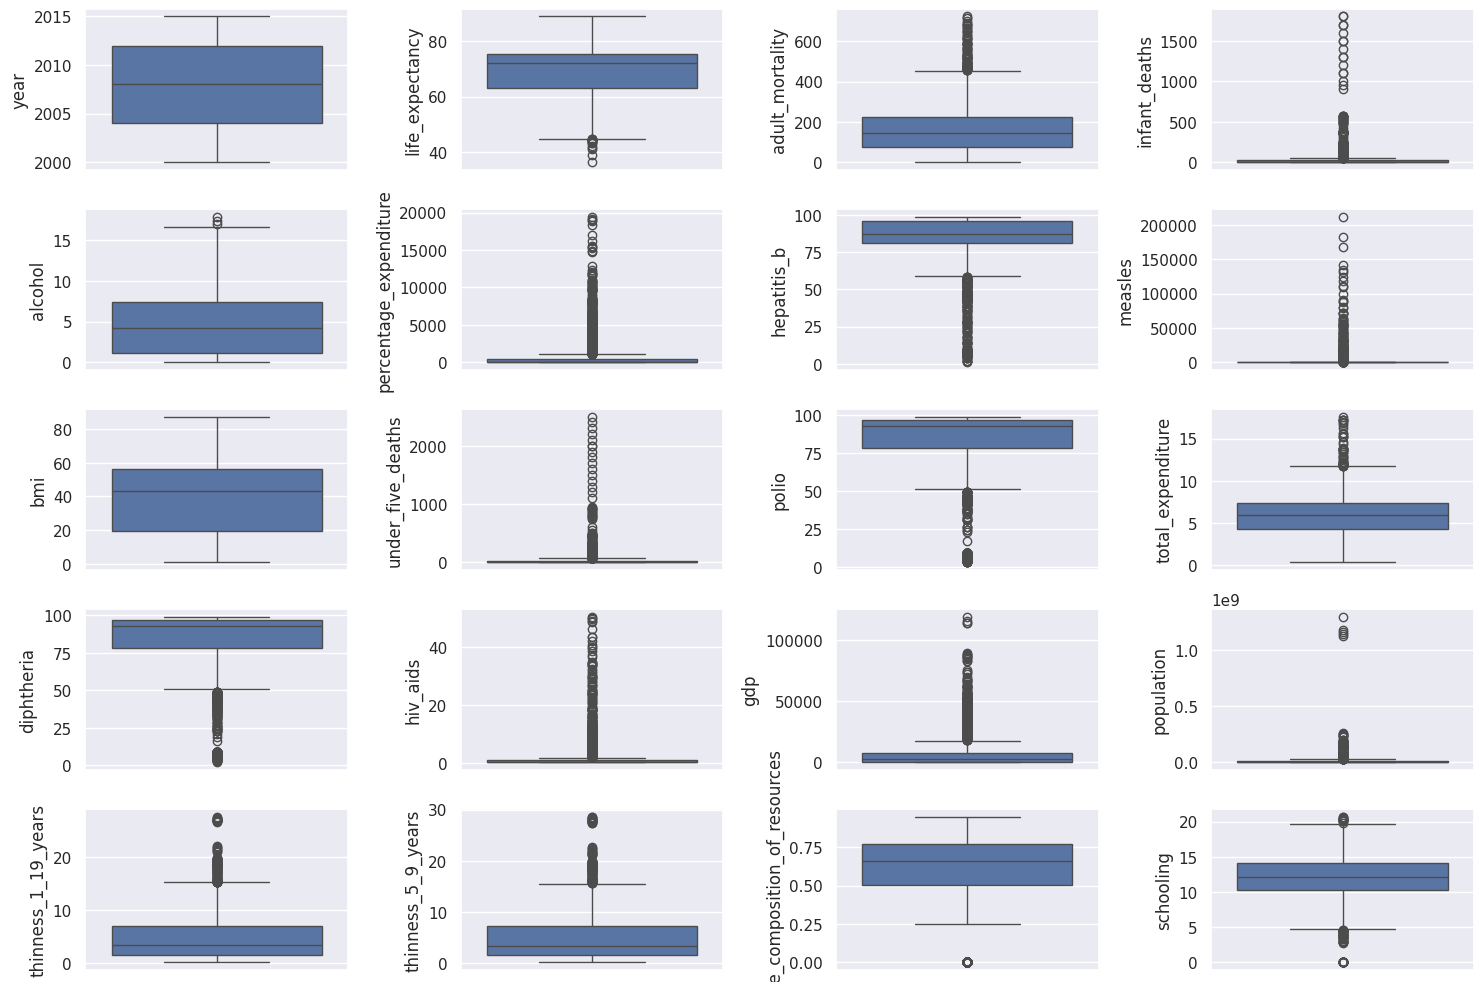

In [255]:
# Plot outliers
plot_outliers()

In [256]:
# Handler outliers
fix_outliers(data)

In [257]:
# Get the columns with outliers
get_outlier_columns(data)

Index([], dtype='object')

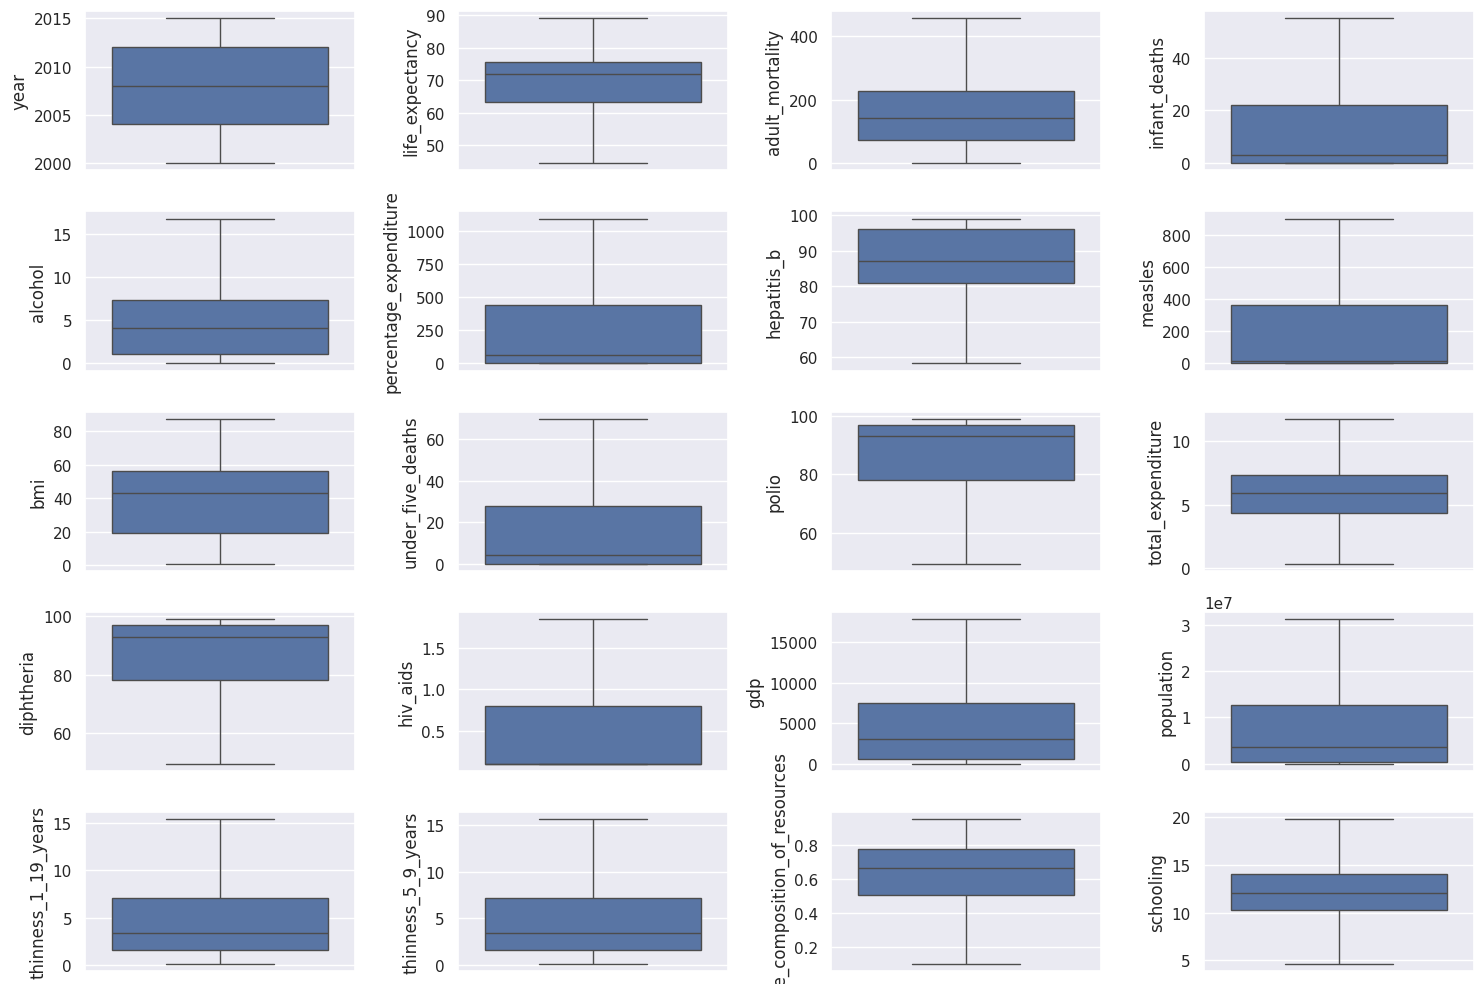

In [258]:
# Plot outliers
plot_outliers()

In [259]:
# Encode status columns
print(f"Unique values in status columns before encoding:\n\n{data.status.value_counts()}")
data.status = data.status.map({"Developing": 0, "Developed": 1})
print(f"Unique values in status columns after encoding:\n\n{data.status.value_counts()}")

Unique values in status columns before encoding:

status
Developing    2426
Developed      512
Name: count, dtype: int64
Unique values in status columns after encoding:

status
0    2426
1     512
Name: count, dtype: int64


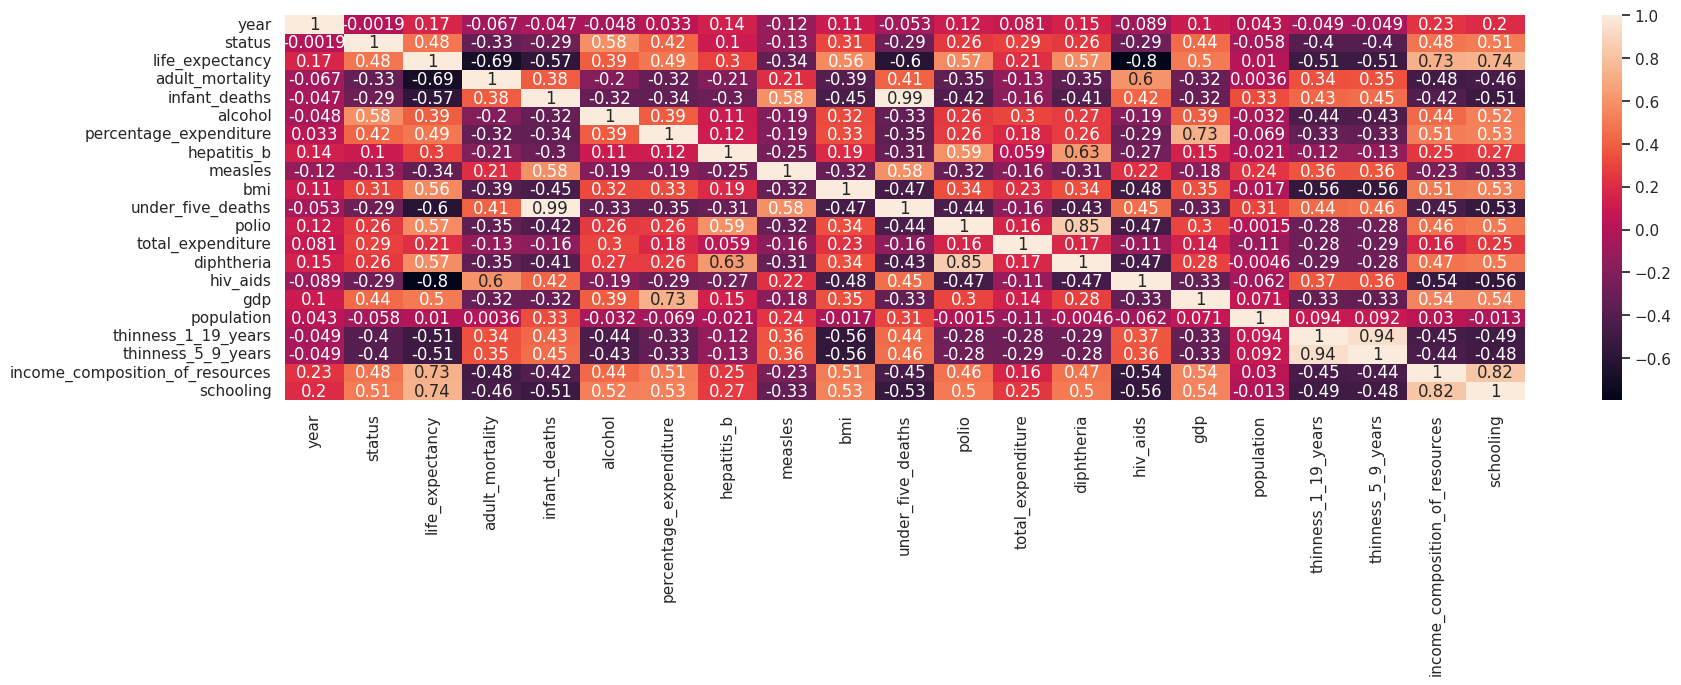

In [260]:
# Check correlation
plt.subplots(1,1, figsize=(20, 5))
sns.heatmap(data.corr(), annot=True)
plt.show()

In [261]:
# All the features have correlation with target though few of feature have very low correlation. Lets use all feature for building initial model

# Split the data into feature matrix and target vector
X = data.drop(['life_expectancy'], axis=1)
y = data[['life_expectancy']]
print(f"Dimension of Features:{X.shape}")
print(f"Dimension of Target:{y.shape}")

Dimension of Features:(2938, 20)
Dimension of Target:(2938, 1)


# OLS

In [262]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=True)
print(f"Dimension of X_train:{X_train.shape}")
print(f"Dimension of X_test:{X_test.shape}")
print(f"Dimension of y_train:{y_train.shape}")
print(f"Dimension of y_test:{y_test.shape}")

Dimension of X_train:(2056, 20)
Dimension of X_test:(882, 20)
Dimension of y_train:(2056, 1)
Dimension of y_test:(882, 1)


In [263]:
# Feature scaling
scalar = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scalar.transform(X_train), columns=scalar.get_feature_names_out())
X_test_scaled =  pd.DataFrame(scalar.transform(X_test), columns=scalar.get_feature_names_out())

In [264]:
# Add a constant term
X_train_scaled_sm = sm.add_constant(X_train_scaled)
X_test_scaled_sm = sm.add_constant(X_test_scaled)

In [265]:
# Build OLS model
ols_lr = sm.OLS(y_train.reset_index(drop=True), X_train_scaled_sm).fit()

In [266]:
# Dispay the model summary
print(ols_lr.summary())

                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     617.6
Date:                Wed, 02 Oct 2024   Prob (F-statistic):               0.00
Time:                        14:18:43   Log-Likelihood:                -5546.9
No. Observations:                2056   AIC:                         1.114e+04
Df Residuals:                    2035   BIC:                         1.125e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [267]:
# Check mean sqaured error and residual sum of square for training data
y_train_pred = ols_lr.predict(X_train_scaled_sm)
residual = np.array(y_train.reset_index(drop=True)).flatten() - np.array(y_train_pred).flatten()
print(f"Training MSE: {mean_squared_error(y_train.reset_index(drop=True), y_train_pred)}")
print(f"Training MAE: {median_absolute_error(y_train.reset_index(drop=True), y_train_pred)}")
print(f"Training SSR: {np.sum(residual**2)}")
print(f"Training score: {r2_score(y_train.reset_index(drop=True), y_train_pred)}")

Training MSE: 12.908700015087433
Training MAE: 2.113621859146903
Training SSR: 26540.287231019764
Training score: 0.858551121367116


In [268]:
# Make predictions for the new data
y_test_pred = ols_lr.predict(X_test_scaled_sm)
residual = np.array(y_test.reset_index(drop=True)).flatten() - np.array(y_test_pred).flatten()
print(f"Testing MSE: {mean_squared_error(y_test.reset_index(drop=True), y_test_pred)}")
print(f"Testing MAE: {median_absolute_error(y_test.reset_index(drop=True), y_test_pred)}")
print(f"Testing SSR: {np.sum(residual**2)}")
print(f"Testing score: {r2_score(y_test.reset_index(drop=True), y_test_pred)}")

Testing MSE: 13.01920603863846
Testing MAE: 2.0596461207939
Testing SSR: 11482.939726079121
Testing score: 0.84949025013026


### Model Performance Interpretation
- Model perform similar on both training and testing data, showing a good generalization
- From the p-values in regression output, measles, bmi, and total_expenditure have very high p-values (greater than 0.05), indicating that they are not contributing significantly to the model.

### Check Multicolinearity

In [269]:
# Check multicolinearity using VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_df = pd.DataFrame()
vif_df['Features'] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df)


                           Features         VIF
0                              year  114.741239
1                            status    2.245279
2                   adult_mortality    5.159578
3                     infant_deaths  165.684823
4                           alcohol    4.434049
5            percentage_expenditure    3.636993
6                       hepatitis_b   78.078351
7                           measles    2.326145
8                               bmi    8.703334
9                 under_five_deaths  173.178475
10                            polio  114.550372
11                total_expenditure    9.227670
12                       diphtheria  123.474507
13                         hiv_aids    3.672354
14                              gdp    4.564551
15                       population    2.233258
16              thinness_1_19_years   22.523542
17               thinness_5_9_years   22.557988
18  income_composition_of_resources   42.281085
19                        schooling   66

From the results, we can can see that some features have very high Variance Inflation Factor (VIF) values, indicating severe multicollinearity

# Ridge Regression

In [270]:
# Simple Ridge Regression
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()), ('ridge', Ridge(random_state=42))
])

pipeline.fit(X_train, y_train)
y_train_pred = pipeline.predict(X_train)

residual = np.array(y_train.reset_index(drop=True)).flatten() - np.array(y_train_pred).flatten()
print(f"Training MSE: {mean_squared_error(y_train.reset_index(drop=True), y_train_pred)}")
print(f"Training MAE: {median_absolute_error(y_train.reset_index(drop=True), y_train_pred)}")
print(f"Training SSR: {np.sum(residual**2)}")
print(f"Training score: {r2_score(y_train.reset_index(drop=True), y_train_pred)}")

Training MSE: 12.91149574226996
Training MAE: 2.115193311883573
Training SSR: 26546.035246107036
Training score: 0.8585204867970609


In [271]:
# Predication for the new data
y_test_pred = pipeline.predict(X_test)
residual = np.array(y_test.reset_index(drop=True)).flatten() - np.array(y_test_pred).flatten()
print(f"Testing MSE: {mean_squared_error(y_test.reset_index(drop=True), y_test_pred)}")
print(f"Testing MAE: {median_absolute_error(y_test.reset_index(drop=True), y_test_pred)}")
print(f"Testing SSR: {np.sum(residual**2)}")
print(f"Testing score: {r2_score(y_test.reset_index(drop=True), y_test_pred)}")

Testing MSE: 13.029911288409316
Testing MAE: 2.062607954139807
Testing SSR: 11492.381756377017
Testing score: 0.8493664910883858


Simple Ridge Regression results are more are less same as OLS.

In [272]:
# Cross validation for alpha
from sklearn.linear_model import RidgeCV
ridgs_cv_pipeline = Pipeline([
    ('scale' , StandardScaler()), ('ridge_cv', RidgeCV(alphas=[0.01,0.1,1,2,3,4,5,10], store_cv_values=True))
])
ridgs_cv_pipeline.fit(X_train, y_train)
print(f"Best alpha: {ridgs_cv_pipeline.named_steps['ridge_cv'].alpha_}")

Best alpha: 0.1


In [273]:
# Build Regression model using best alpha

ridge_best_alpha_pipeline = Pipeline([('scalar', StandardScaler()), ('ridge_best_alpha', Ridge(alpha=0.1))])
ridge_best_alpha_pipeline.fit(X_train, y_train)
y_train_pred = ridge_best_alpha_pipeline.predict(X_train)

residual = np.array(y_train.reset_index(drop=True)).flatten() - np.array(y_train_pred).flatten()
print(f"Training MSE: {mean_squared_error(y_train.reset_index(drop=True), y_train_pred)}")
print(f"Training MAE: {median_absolute_error(y_train.reset_index(drop=True), y_train_pred)}")
print(f"Training SSR: {np.sum(residual**2)}")
print(f"Training score: {r2_score(y_train.reset_index(drop=True), y_train_pred)}")

Training MSE: 12.908733109125178
Training MAE: 2.1115905993982125
Training SSR: 26540.355272361365
Training score: 0.8585507587345873


In [274]:
# Predication on new data using

y_test_pred = ridge_best_alpha_pipeline.predict(X_test)
residual = np.array(y_test.reset_index(drop=True)).flatten() - np.array(y_test_pred).flatten()
print(f"Testing MSE: {mean_squared_error(y_test.reset_index(drop=True), y_test_pred)}")
print(f"Testing MAE: {median_absolute_error(y_test.reset_index(drop=True), y_test_pred)}")
print(f"Testing SSR: {np.sum(residual**2)}")
print(f"Testing score: {r2_score(y_test.reset_index(drop=True), y_test_pred)}")

Testing MSE: 13.020163579744871
Testing MAE: 2.059704987784471
Testing SSR: 11483.784277334977
Testing score: 0.8494791803866837


We can see slight improvement in the model after tuning the alpha

# Ridge With Polinomial

In [276]:
# Lets Perform cross validation to find best polinomioal degree and alpha using GridSearch
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
param_grid = {"poly__degree": [1, 2, 3, 4, 5], "ridge__alpha": [0.01, 0.01, 1.0, 10]}

grid_search_pipeline = Pipeline([("poly", PolynomialFeatures(include_bias=False)), ("scalar", StandardScaler()), ("ridge", Ridge())])

grid_search = GridSearchCV(grid_search_pipeline, param_grid, scoring='r2')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

In [278]:
print(f"Best polinomial degree: {best_params['poly__degree']}")
print(f"Best Alpha for Ridge: {best_params['ridge__alpha']}")
print(f"Best Score: {grid_search.best_estimator_.score(X_train, y_train)}")

Best polinomial degree: 3
Best Alpha for Ridge: 10
Best Score: 0.9623985605651737


In [277]:
# Lets build the Ridge with polinomial using polinomial degree as 3 and and aplha as 10

ridge_poly_pipeline = Pipeline([('poly', PolynomialFeatures(degree=3, include_bias=False)),
                               ('scalar', StandardScaler()),
                               ('ridge_poly', Ridge(alpha=10))
                               ])
ridge_poly_pipeline.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False)),
                ('scalar', StandardScaler()), ('ridge_poly', Ridge(alpha=10))])

In [279]:
# Training metrics
y_train_pred = ridge_poly_pipeline.predict(X_train)
residual = np.array(y_train.reset_index(drop=True)).flatten() - np.array(y_train_pred).flatten()
print(f"Training MSE: {mean_squared_error(y_train.reset_index(drop=True), y_train_pred)}")
print(f"Training MAE: {median_absolute_error(y_train.reset_index(drop=True), y_train_pred)}")
print(f"Training SSR: {np.sum(residual**2)}")
print(f"Training score: {r2_score(y_train.reset_index(drop=True), y_train_pred)}")

Training MSE: 3.4315273934367485
Training MAE: 0.9131748129541535
Training SSR: 7055.220320905955
Training score: 0.9623985605651737


In [280]:
# Predication for the test data
y_test_pred = ridge_poly_pipeline.predict(X_test)
residual = np.array(y_test.reset_index(drop=True)).flatten() - np.array(y_test_pred).flatten()
print(f"Testing MSE: {mean_squared_error(y_test.reset_index(drop=True), y_test_pred)}")
print(f"Testing MAE: {median_absolute_error(y_test.reset_index(drop=True), y_test_pred)}")
print(f"Testing SSR: {np.sum(residual**2)}")
print(f"Testing score: {r2_score(y_test.reset_index(drop=True), y_test_pred)}")

Testing MSE: 6.529449616052957
Testing MAE: 1.162694184792855
Testing SSR: 5758.974561358707
Testing score: 0.9245156866261581


# Lasso: Feature Selection

In [291]:
from sklearn.linear_model import LassoCV

lasso_cv_pipeline = Pipeline([('scalar', StandardScaler()), ('lasso_cv', LassoCV(random_state=42))])
lasso_cv_pipeline.fit(X_train, y_train)
lasso_cv_pipeline.named_steps['lasso_cv'].coef_
selected_features = np.where(lasso_cv_pipeline.named_steps['lasso_cv'].coef_ != 0)[0]
X_train_selected = X_train.iloc[:,selected_features]
X_test_selected = X_test.iloc[:,selected_features]

# Build Ridge Polinomial using Selected features

In [303]:
# Build Ridge Poly using selected features and best poly degree and alpha
ridge_poly_cv_sel_feature_pipeline = Pipeline([('poly', PolynomialFeatures(include_bias=False)),('scalar', StandardScaler()),('ridge', Ridge())])

grid_param = {
    'poly__degree':[1, 2, 3, 4],
    'ridge__alpha':[0.01, 0.1, 1, 10, 100]
}


grid_search_sel_feature = GridSearchCV(ridge_poly_cv_sel_feature_pipeline, grid_param, scoring='r2')
grid_search_sel_feature.fit(X_train_selected, y_train)

best_degree = grid_search_sel_feature.best_params_['poly__degree']
best_alpha = grid_search_sel_feature.best_params_['ridge__alpha']

print(f"Best Polinomial Degree: {best_degree}")
print(f"Best Alpha for Ridge: {best_alpha}")
print(f"Best Score: {grid_search_sel_feature.best_estimator_.score(X_train_selected, y_train)}")

ridge_poly_selected_feature_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
     ('scalar', StandardScaler()),
      ('ridge_poly_selected_feature', Ridge(alpha=best_alpha))
])

ridge_poly_selected_feature_pipeline.fit(X_train_selected, y_train)

Best Polinomial Degree: 4
Best Alpha for Ridge: 100
Best Score: 0.957535600271662


Pipeline(steps=[('poly', PolynomialFeatures(degree=4, include_bias=False)),
                ('scalar', StandardScaler()),
                ('ridge_poly_selected_feature', Ridge(alpha=100))])

In [304]:
# Predication for training data set
y_train_pred = ridge_poly_selected_feature_pipeline.predict(X_train_selected)
residual = np.array(y_train.reset_index(drop=True)).flatten() - np.array(y_train_pred).flatten()
print(f"Training MSE: {mean_squared_error(y_train.reset_index(drop=True), y_train_pred)}")
print(f"Training MAE: {median_absolute_error(y_train.reset_index(drop=True), y_train_pred)}")
print(f"Training SSR: {np.sum(residual**2)}")
print(f"Training score: {r2_score(y_train.reset_index(drop=True), y_train_pred)}")

Training MSE: 3.8753237403639647
Training MAE: 0.9284499309382923
Training SSR: 7967.665610188311
Training score: 0.957535600271662


In [305]:
# Predication for testing data set
# Predication for the test data
y_test_pred = ridge_poly_selected_feature_pipeline.predict(X_test_selected)
residual = np.array(y_test.reset_index(drop=True)).flatten() - np.array(y_test_pred).flatten()
print(f"Testing MSE: {mean_squared_error(y_test.reset_index(drop=True), y_test_pred)}")
print(f"Testing MAE: {median_absolute_error(y_test.reset_index(drop=True), y_test_pred)}")
print(f"Testing SSR: {np.sum(residual**2)}")
print(f"Testing score: {r2_score(y_test.reset_index(drop=True), y_test_pred)}")

Testing MSE: 6.181396479555884
Testing MAE: 1.147205284513337
Testing SSR: 5451.99169496829
Testing score: 0.9285393874847269
